## Figures Assessing bioinformatics software annotations: bio.tools case-study

### Figure 1 : Direct and inferred EDAM annotations for the scientific topic of Qiime2 and Vsearch, two metagenomics tools

In [9]:
#Python 3.13.1
#Import library 
import pandas as pd
import IPython
import collections
import pygraphviz as pgv
from SPARQLWrapper import SPARQLWrapper, JSON
#Read csv 
dfTool = pd.read_csv("../Dataframes/dfTool.tsv.bz2", sep="\t") #all Tool and toolLabel
dfToolTopicTransitive = pd.read_csv("../Dataframes/dfToolTopicTransitive.tsv.bz2", sep="\t")#Tool, topic, topicLabel inherited annotation
dfToolOperationTransitive = pd.read_csv("../Dataframes/dfToolOperationTransitive.tsv.bz2", sep="\t")# tool, operation, operationLabel inherited annotation

#Configuration SPARQL end point 
endpointURL = "http://localhost:3030/biotoolsEdam/query"
rdfFormat = "turtle"
query="""
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>

SELECT ?ontology ?versionIRI (REPLACE(STR(?versionIRI), 'http://edamontology.org/', '') AS ?versionNumber)
WHERE {
  ?ontology rdf:type owl:Ontology .
  ?ontology owl:versionIRI ?versionIRI .
}
"""

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

chebiVersion = float(results["results"]["bindings"][0]["versionNumber"]["value"])
print("EDAM version: {}".format(chebiVersion))

#Import prefix : 
prefixes = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX oboInOwl: <http://www.geneontology.org/formats/oboInOwl#>

PREFIX bt: <https://bio.tools/>
PREFIX biotools: <https://bio.tools/ontology/>
PREFIX bsc: <http://bioschemas.org/>
PREFIX bsct: <http://bioschemas.org/types/>
PREFIX edam: <http://edamontology.org/>
PREFIX sc: <http://schema.org/>
PREFIX schema: <https://schema.org/>

"""

#Link tool
biotoolsURI = "https://bio.tools/"
biotoolsOntologyURI = "https://bio.tools/ontology/"
edamURI = "http://edamontology.org/"

EDAM version: 1.25


In [5]:
def addToolAndAnnotationsToGraph(toolURI, graph=None, showTopics=True, showOperations=True, showDeprecatedAnnotations=False, highlightDirectAnnotations=False):
    """Return a graph representing a tool and its EDAM annotations.

    Keyword arguments:
    toolURI -- the URI for the tool
    graph -- the graph in which the tool and its annotations are added. A new graph is created if the value is None. (default: None)
    showTopics -- should the topics annotating the tool be considered (default: True)
    showOperations -- should the operations annotating the tool be considered (default: True)
    showDeprecatedAnnotations -- should the deprecated topics and operations annotating the tool be considered (default: False)
    highlightDirectAnnotations -- should the topics or operations annotated directly be highliigthed (default:False)
    """
    if graph is None:
        graph = pgv.AGraph(directed=True, rankdir="BT")
    
    toolIdent = toolURI.replace(biotoolsURI, "")
    
    if toolURI.startswith("http"):
        toolURI = "<" + toolURI + ">"
        
    directAnnotationColor = "red" if highlightDirectAnnotations else "black"
    
    conceptStyle = {}
    conceptStyle['Tool'] = "filled"
    conceptStyle['Topic'] = "filled"
    conceptStyle['TopicDeprecated'] = conceptStyle['Topic']+",dashed"
    conceptStyle['TopicAlternative'] = conceptStyle['Topic']+",dotted"
    conceptStyle['Operation'] = "rounded,filled"
    conceptStyle['OperationDeprecated'] = conceptStyle['Operation']+",dashed"
    conceptStyle['OperationAlternative'] = conceptStyle['Operation']+",dotted"
    
    query = """
SELECT DISTINCT ?toolLabel 
WHERE {
  VALUES ?tool { """ + toolURI + """ }

  ?tool rdf:type sc:SoftwareApplication .
  OPTIONAL { ?tool sc:name ?tLabel }
  BIND(COALESCE(?tLabel, "") AS ?toolLabel)
}
"""
    sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(prefixes+query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    for result in results["results"]["bindings"]:
        #print("{}\t{}".format(toolIdent, result["toolLabel"]["value"]))
        if not graph.has_node(toolIdent):
            clusterTools = graph.get_subgraph(name="cluster_tools")
            if clusterTools is None:
                clusterTools = graph.add_subgraph(name="cluster_tools", rankdir="same", style="invis") # style="invis"
            clusterTools.add_node(toolIdent, label="{}".format(result["toolLabel"]["value"]), shape="ellipse", color="blue", nodeType="Tool", style=conceptStyle["Tool"], fillcolor="#ffffff")
    
    directConcepts = []
    if showTopics:
        directConcepts = []
        conceptType = "Topic"
        query = """
SELECT DISTINCT ?conceptURI ?conceptLabel
WHERE {
  VALUES ?tool { """ + toolURI + """ }

  ?tool sc:applicationSubCategory ?conceptURI .
  ?conceptURI rdf:type owl:Class .
  FILTER NOT EXISTS { ?conceptURI rdfs:subClassOf? owl:DeprecatedClass }
  OPTIONAL { ?conceptURI rdfs:label ?cLabel }
  BIND(COALESCE(?cLabel, "") AS ?conceptLabel)
}
"""
        sparql = SPARQLWrapper(endpointURL)
        sparql.setQuery(prefixes+query)
        sparql.setReturnFormat(JSON)
        results = sparql.query().convert()
        for result in results["results"]["bindings"]:
            directConcepts.append(result["conceptURI"]["value"])
            conceptIdent = result["conceptURI"]["value"].replace(edamURI, "")
            #print("\t{}\t{}".format(conceptIdent, result["conceptLabel"]["value"]))
            if not graph.has_node(conceptIdent):
                graph.add_node(conceptIdent, label="{}\n({})".format(result["conceptLabel"]["value"], conceptIdent), nodeType=conceptType, shape="box", color=directAnnotationColor, style=conceptStyle[conceptType], fillcolor="#ffffff")
            graph.add_edge(toolIdent, conceptIdent, arrowhead="vee", color="blue", fontcolor="blue", style="dashed")
    
    for conceptURI in directConcepts:
        query = """
SELECT DISTINCT ?subConceptURI ?subConceptLabel ?superConceptURI ?superConceptLabel 
WHERE {
  VALUES ?conceptURI { <""" + conceptURI + """> }
  ?conceptURI rdfs:subClassOf* ?subConceptURI .
  ?subConceptURI rdf:type owl:Class .
  FILTER NOT EXISTS { ?subConceptURI rdfs:subClassOf? owl:DeprecatedClass }
  OPTIONAL { ?subConceptURI rdfs:label ?subLabel }
  ?subConceptURI rdfs:subClassOf ?superConceptURI .
  ?superConceptURI rdf:type owl:Class .
  FILTER NOT EXISTS { ?superConceptURI rdfs:subClassOf? owl:DeprecatedClass }
  OPTIONAL { ?superConceptURI rdfs:label ?supLabel }
  BIND(COALESCE(?subLabel, "") AS ?subConceptLabel)
  BIND(COALESCE(?supLabel, "") AS ?superConceptLabel)
}
"""
        sparql = SPARQLWrapper(endpointURL)
        sparql.setQuery(prefixes+query)
        sparql.setReturnFormat(JSON)
        results = sparql.query().convert()
        directConcepts = []
        for result in results["results"]["bindings"]:
            subConceptIdent = result["subConceptURI"]["value"].replace(edamURI, "")
            superConceptIdent = result["superConceptURI"]["value"].replace(edamURI, "")
            if not graph.has_node(subConceptIdent):
                graph.add_node(subConceptIdent, label="{}\n{}".format(result["subConceptLabel"]["value"], subConceptIdent), shape="box", color="black", nodeType=conceptType, style=conceptStyle[conceptType], fillcolor="#ffffff")
            if not graph.has_node(superConceptIdent):
                graph.add_node(superConceptIdent, label="{}\n{}".format(result["superConceptLabel"]["value"], superConceptIdent), shape="box", color="black", nodeType=conceptType, style=conceptStyle[conceptType], fillcolor="#ffffff")
            graph.add_edge(subConceptIdent, superConceptIdent, arrowhead="onormal")
            
            
    if showOperations:
        directConcepts = []
        conceptType = "Operation"
        query = """
SELECT DISTINCT ?conceptURI ?conceptLabel
WHERE {
  VALUES ?tool { """ + toolURI + """ }

  ?tool sc:featureList ?conceptURI .
  ?conceptURI rdf:type owl:Class .
  FILTER NOT EXISTS { ?conceptURI rdfs:subClassOf? owl:DeprecatedClass }
  OPTIONAL { ?conceptURI rdfs:label ?cLabel }
  BIND(COALESCE(?cLabel, "") AS ?conceptLabel)
}
"""
        sparql = SPARQLWrapper(endpointURL)
        sparql.setQuery(prefixes+query)
        sparql.setReturnFormat(JSON)
        results = sparql.query().convert()
        for result in results["results"]["bindings"]:
            directConcepts.append(result["conceptURI"]["value"])
            conceptIdent = result["conceptURI"]["value"].replace(edamURI, "")
            #print("\t{}\t{}".format(conceptIdent, result["conceptLabel"]["value"]))
            if not graph.has_node(conceptIdent):
                graph.add_node(conceptIdent, label="{}\n({})".format(result["conceptLabel"]["value"], conceptIdent), nodeType=conceptType, shape="box", color=directAnnotationColor, style=conceptStyle[conceptType], fillcolor="#ffffff")
            graph.add_edge(toolIdent, conceptIdent, arrowhead="vee", color="blue", fontcolor="blue", style="dashed")
    
    for conceptURI in directConcepts:
        query = """
SELECT DISTINCT ?subConceptURI ?subConceptLabel ?superConceptURI ?superConceptLabel 
WHERE {
  VALUES ?conceptURI { <""" + conceptURI + """> }
  ?conceptURI rdfs:subClassOf* ?subConceptURI .
  ?subConceptURI rdf:type owl:Class .
  FILTER NOT EXISTS { ?subConceptURI rdfs:subClassOf? owl:DeprecatedClass }
  OPTIONAL { ?subConceptURI rdfs:label ?subLabel }
  ?subConceptURI rdfs:subClassOf ?superConceptURI .
  ?superConceptURI rdf:type owl:Class .
  FILTER NOT EXISTS { ?superConceptURI rdfs:subClassOf? owl:DeprecatedClass }
  OPTIONAL { ?superConceptURI rdfs:label ?supLabel }
  BIND(COALESCE(?subLabel, "") AS ?subConceptLabel)
  BIND(COALESCE(?supLabel, "") AS ?superConceptLabel)
}
"""
        sparql = SPARQLWrapper(endpointURL)
        sparql.setQuery(prefixes+query)
        sparql.setReturnFormat(JSON)
        results = sparql.query().convert()
        directConcepts = []
        for result in results["results"]["bindings"]:
            subConceptIdent = result["subConceptURI"]["value"].replace(edamURI, "")
            superConceptIdent = result["superConceptURI"]["value"].replace(edamURI, "")
            if not graph.has_node(subConceptIdent):
                graph.add_node(subConceptIdent, label="{}\n{}".format(result["subConceptLabel"]["value"], subConceptIdent), shape="box", color="black", nodeType=conceptType, style=conceptStyle[conceptType], fillcolor="#ffffff")
            if not graph.has_node(superConceptIdent):
                graph.add_node(superConceptIdent, label="{}\n{}".format(result["superConceptLabel"]["value"], superConceptIdent), shape="box", color="black", nodeType=conceptType, style=conceptStyle[conceptType], fillcolor="#ffffff")
            graph.add_edge(subConceptIdent, superConceptIdent, arrowhead="onormal")
    
    if showDeprecatedAnnotations:
        #conceptType = "TopicDeprecated"
        query = """
SELECT DISTINCT ?conceptURI ?conceptLabel ?conceptAlternative ?conceptAlternativeLabel
WHERE {
  VALUES ?tool { """ + toolURI + """ }

  ?tool sc:applicationSubCategory ?conceptURI .
  #?conceptURI rdf:type owl:Class .
  { ?conceptURI rdfs:subClassOf? owl:DeprecatedClass }
  UNION
  { ?conceptURI owl:deprecated true }
  UNION
  { ?conceptURI owl:deprecated "true" }
  UNION
  { ?conceptURI owl:deprecated "True" }
  OPTIONAL { ?conceptURI rdfs:label ?cLabel }
  BIND(COALESCE(?cLabel, "") AS ?conceptLabel)
  
  OPTIONAL {
    ?conceptURI oboInOwl:consider ?conceptAlternative .
    OPTIONAL { ?conceptAlternative rdfs:label ?caLabel }
    BIND(COALESCE(?caLabel, "") AS ?conceptAlternativeLabel)
  }
}
"""
        sparql = SPARQLWrapper(endpointURL)
        sparql.setQuery(prefixes+query)
        sparql.setReturnFormat(JSON)
        results = sparql.query().convert()
        for result in results["results"]["bindings"]:
            conceptType = "TopicDeprecated"
            directConcepts.append(result["conceptURI"]["value"])
            conceptIdent = result["conceptURI"]["value"].replace(edamURI, "")
            #print("\t{}\t{}".format(conceptIdent, result["conceptLabel"]["value"]))
            if not graph.has_node(conceptIdent):
                graph.add_node(conceptIdent, label="{}\n({})".format(result["conceptLabel"]["value"], conceptIdent), nodeType=conceptType, shape="box", color="grey", style=conceptStyle[conceptType], fillcolor="#ffffff")
            graph.add_edge(toolIdent, conceptIdent, arrowhead="vee", color="grey", fontcolor="grey", style="dashed")
            if "conceptAlternative" in result.keys():
                conceptType = "TopicAlternative"
                alternativeIdent = result["conceptAlternative"]["value"].replace(edamURI, "")
                if not graph.has_node(alternativeIdent):
                    graph.add_node(alternativeIdent, label="{}\n({})".format(result["conceptAlternativeLabel"]["value"], alternativeIdent), nodeType=conceptType, shape="box", color="grey", style=conceptStyle[conceptType], fillcolor="#ffffff")
                    queryHierarchy = """
SELECT DISTINCT ?subConceptURI ?subConceptLabel ?superConceptURI ?superConceptLabel 
WHERE {
  VALUES ?conceptURI { <""" + alternativeURI + """> }
  ?conceptURI rdfs:subClassOf* ?subConceptURI .
  ?subConceptURI rdf:type owl:Class .
  FILTER NOT EXISTS { ?subConceptURI rdfs:subClassOf? owl:DeprecatedClass }
  OPTIONAL { ?subConceptURI rdfs:label ?subLabel }
  ?subConceptURI rdfs:subClassOf ?superConceptURI .
  ?superConceptURI rdf:type owl:Class .
  FILTER NOT EXISTS { ?superConceptURI rdfs:subClassOf? owl:DeprecatedClass }
  OPTIONAL { ?superConceptURI rdfs:label ?supLabel }
  BIND(COALESCE(?subLabel, "") AS ?subConceptLabel)
  BIND(COALESCE(?supLabel, "") AS ?superConceptLabel)
}
"""
                    sparqlHierarchy = SPARQLWrapper(endpointURL)
                    sparqlHierarchy.setQuery(prefixes+queryHierarchy)
                    sparqlHierarchy.setReturnFormat(JSON)
                    resultsHierarchy = sparqlHierarchy.query().convert()
                    for resultHierarchy in resultsHierarchy["results"]["bindings"]:
                        subConceptIdent = resultHierarchy["subConceptURI"]["value"].replace(edamURI, "")
                        superConceptIdent = resultHierarchy["superConceptURI"]["value"].replace(edamURI, "")
                        if not graph.has_node(subConceptIdent):
                            graph.add_node(subConceptIdent, label="{}\n{}".format(resultHierarchy["subConceptLabel"]["value"], subConceptIdent), shape="box", color="grey", nodeType=conceptType, style=conceptStyle[conceptType], fillcolor="#ffffff")
                        if not graph.has_node(superConceptIdent):
                            graph.add_node(superConceptIdent, label="{}\n{}".format(resultHierarchy["superConceptLabel"]["value"], superConceptIdent), shape="box", color="grey", nodeType=conceptType, style=conceptStyle[conceptType], fillcolor="#ffffff")
                        if not graph.has_edge(subConceptIdent, superConceptIdent):
                            graph.add_edge(subConceptIdent, superConceptIdent, arrowhead="onormal", color="grey", style="dotted")
                
                graph.add_edge(conceptIdent, alternativeIdent, arrowhead="vee", color="grey", fontcolor="grey", style="dotted")
    
        
        #conceptType = "OperationDeprecated"
        query = """
SELECT DISTINCT ?conceptURI ?conceptLabel ?conceptAlternative ?conceptAlternativeLabel
WHERE {
  VALUES ?tool { """ + toolURI + """ }

  ?tool sc:featureList ?conceptURI .
  #?conceptURI rdf:type owl:Class .
  { ?conceptURI rdfs:subClassOf? owl:DeprecatedClass }
  UNION
  { ?conceptURI owl:deprecated true }
  UNION
  { ?conceptURI owl:deprecated "true" }
  UNION
  { ?conceptURI owl:deprecated "True" }
  OPTIONAL { ?conceptURI rdfs:label ?cLabel }
  BIND(COALESCE(?cLabel, "") AS ?conceptLabel)
  
  OPTIONAL {
    ?conceptURI oboInOwl:consider ?conceptAlternative .
    OPTIONAL { ?conceptAlternative rdfs:label ?caLabel }
    BIND(COALESCE(?caLabel, "") AS ?conceptAlternativeLabel)
  }
}
"""
        sparql = SPARQLWrapper(endpointURL)
        sparql.setQuery(prefixes+query)
        sparql.setReturnFormat(JSON)
        results = sparql.query().convert()
        for result in results["results"]["bindings"]:
            conceptType = "OperationDeprecated"
            directConcepts.append(result["conceptURI"]["value"])
            conceptIdent = result["conceptURI"]["value"].replace(edamURI, "")
            #print("\t{}\t{}".format(conceptIdent, result["conceptLabel"]["value"]))
            if not graph.has_node(conceptIdent):
                graph.add_node(conceptIdent, label="{}\n({})".format(result["conceptLabel"]["value"], conceptIdent), nodeType=conceptType, shape="box", color="grey", style=conceptStyle[conceptType], fillcolor="#ffffff")
            graph.add_edge(toolIdent, conceptIdent, arrowhead="vee", color="grey", fontcolor="grey", style="dashed")
            if "conceptAlternative" in result.keys():
                conceptType = "OperationAlternative"
                alternativeURI = result["conceptAlternative"]["value"]
                alternativeIdent = alternativeURI.replace(edamURI, "")
                if not graph.has_node(alternativeIdent):
                    graph.add_node(alternativeIdent, label="{}\n({})".format(result["conceptAlternativeLabel"]["value"], alternativeIdent), nodeType=conceptType, shape="box", color="grey", style=conceptStyle[conceptType], fillcolor="#ffffff")
                    queryHierarchy = """
SELECT DISTINCT ?subConceptURI ?subConceptLabel ?superConceptURI ?superConceptLabel 
WHERE {
  VALUES ?conceptURI { <""" + alternativeURI + """> }
  ?conceptURI rdfs:subClassOf* ?subConceptURI .
  ?subConceptURI rdf:type owl:Class .
  FILTER NOT EXISTS { ?subConceptURI rdfs:subClassOf? owl:DeprecatedClass }
  OPTIONAL { ?subConceptURI rdfs:label ?subLabel }
  ?subConceptURI rdfs:subClassOf ?superConceptURI .
  ?superConceptURI rdf:type owl:Class .
  FILTER NOT EXISTS { ?superConceptURI rdfs:subClassOf? owl:DeprecatedClass }
  OPTIONAL { ?superConceptURI rdfs:label ?supLabel }
  BIND(COALESCE(?subLabel, "") AS ?subConceptLabel)
  BIND(COALESCE(?supLabel, "") AS ?superConceptLabel)
}
"""
                    sparqlHierarchy = SPARQLWrapper(endpointURL)
                    sparqlHierarchy.setQuery(prefixes+queryHierarchy)
                    sparqlHierarchy.setReturnFormat(JSON)
                    resultsHierarchy = sparqlHierarchy.query().convert()
                    for resultHierarchy in resultsHierarchy["results"]["bindings"]:
                        subConceptIdent = resultHierarchy["subConceptURI"]["value"].replace(edamURI, "")
                        superConceptIdent = resultHierarchy["superConceptURI"]["value"].replace(edamURI, "")
                        if not graph.has_node(subConceptIdent):
                            graph.add_node(subConceptIdent, label="{}\n{}".format(resultHierarchy["subConceptLabel"]["value"], subConceptIdent), shape="box", color="grey", nodeType=conceptType, style=conceptStyle[conceptType], fillcolor="#ffffff")
                        if not graph.has_node(superConceptIdent):
                            graph.add_node(superConceptIdent, label="{}\n{}".format(resultHierarchy["superConceptLabel"]["value"], superConceptIdent), shape="box", color="grey", nodeType=conceptType, style=conceptStyle[conceptType], fillcolor="#ffffff")
                        if not graph.has_edge(subConceptIdent, superConceptIdent):
                            graph.add_edge(subConceptIdent, superConceptIdent, arrowhead="onormal", color="grey", style="dotted")
                graph.add_edge(conceptIdent, alternativeIdent, arrowhead="vee", color="grey", fontcolor="grey", style="dotted")
    
    return graph

In [12]:
def get_tool_url(tool_name: str) -> str:
    """Returns the full bio.tools URL for a given tool name, ensuring the correct format."""
    if tool_name.startswith("https://bio.tools/"):
        return tool_name
    return f"https://bio.tools/{tool_name}"


def getToolTopics(tool):
    """
    Returns a list of (topic, topicLabel) tuples for the given tool.
    """
    filtered = dfToolTopicTransitive[dfToolTopicTransitive['tool'] == tool]
    return list(filtered[['topic', 'topicLabel']].itertuples(index=False, name=None))


def getToolOperations(tool):
    """
    Returns a list of (operation, operationLabel) tuples for the given tool.
    """
    filtered = dfToolOperationTransitive[dfToolOperationTransitive['tool'] == tool]
    return list(filtered[['operation', 'operationLabel']].itertuples(index=False, name=None))


def getToolsCommonTopics(listToolURI, transitive=False):
    """Return the list of the (URI, label) tuples for the topics associated to all the tools of a list.

    Keyword arguments:
    listToolURI -- list of the URIs for the tools
    transitive -- also consider the ancestors of the topics directly associated to a tool (default: False)
    """
    commonConcepts = []
    if len(listToolURI) > 0:
        commonConcepts = set(getToolTopics(listToolURI[0]))
    for toolURI in listToolURI[1:]:
        currentConcepts = set(getToolTopics(toolURI))
        commonConcepts = commonConcepts.intersection(currentConcepts)
    return list(commonConcepts)


def getToolsCommonOperations(listToolURI, transitive=False):
    """Return the list of the (URI, label) tuples for the operations associated to all the tools of a list.

    Keyword arguments:
    listToolURI -- list of the URIs for the tools
    transitive -- also consider the ancestors of the operations directly associated to a tool (default: False)
    """
    commonConcepts = []
    if len(listToolURI) > 0:
        commonConcepts = set(getToolOperations(listToolURI[0]))
    for toolURI in listToolURI[1:]:
        currentConcepts = set(getToolOperations(toolURI))
        commonConcepts = commonConcepts.intersection(currentConcepts)
    return list(commonConcepts)


def colorGraphNodesAccordingToScore(graph, dictTopicScore, dictOperationScore, color="red"):
    """Modify nodes color according to a score associated to the node. Nodes that are not associated to a score are unaffected.

    Keyword arguments:
    graph -- the graph to be modified
    dictTopicScore -- a dictionary {nodeIdent -> score} for topic nodes
    dictOperationScore -- a dictionary {nodeIdent -> score} for operation nodes
    color -- name of the color that will vary according to scores. Possible values are "red", "green" or "blue" (default: "red")
    """
    topicMaxValue = max(dictTopicScore.values(), default=0)
    operationMaxValue = max(dictOperationScore.values(), default=0)
    for currentNode in graph.nodes_iter():
        if "nodeType" in currentNode.attr.keys():
            currentNodeType = currentNode.attr['nodeType']
            #currentNode.attr['style'] = conceptStyle[currentNodeType]
            if currentNodeType == "Topic":
                if currentNode in dictTopicScore.keys():
                    graph.get_node(currentNode).attr['fillcolor'] = getScoreColorRGB(dictTopicScore[currentNode], topicMaxValue, color=color)
            elif currentNodeType == "Operation":
                if currentNode in dictOperationScore.keys():
                    graph.get_node(currentNode).attr['fillcolor'] = getScoreColorRGB(dictOperationScore[currentNode], operationMaxValue, color=color)


def addToolsAndAnnotationsToGraph(listToolURI, graph=None, showTopics=True, showOperations=True, highlightDirectAnnotations=False, highlightIntersection=False):
    """Return a graph representing tools and their EDAM annotations.
    
    Keyword arguments:
      listToolURI -- list of the URIs for the tools
      graph -- the graph in which the tool and its annotations are added. A new graph is created if the value is None.
      showTopics -- should the topics annotating the tool be considered
      showOperations -- should the operations annotating the tool be considered
      highlightDirectAnnotations -- should the topics or operations annotated directly be highlighted
      highlightIntersection -- should the common topics or operations common to all the tools be highlighted
    """
    if graph is None:
        graph = pgv.AGraph(directed=True, rankdir="BT")
    
    for toolURI in listToolURI:
        addToolAndAnnotationsToGraph(
            toolURI, 
            graph=graph, 
            showTopics=showTopics, 
            showOperations=showOperations, 
            highlightDirectAnnotations=highlightDirectAnnotations
        )
    
    if highlightIntersection:
        commonConcepts = []
        if showTopics:
            commonConcepts += getToolsCommonTopics(listToolURI, transitive=True)
        if showOperations:
            commonConcepts += getToolsCommonOperations(listToolURI, transitive=True)
    
        for (currentConcept, currentLabel) in commonConcepts:
            currentConceptIdent = currentConcept.replace(edamURI, "")
            node = graph.get_node(currentConceptIdent)
            node.attr['color'] = "red"
            node.attr['penwidth'] = "3"              # Thicker border
            node.attr['style'] = "filled,bold"         # Bold border and filled style
            node.attr['fillcolor'] = "red"             # Red fill to highlight
            node.attr['highlightIntersection'] = "True"  # Mark this node as highlighted
    
    return graph


def getScoreColorRGB(scoreValue, scoreMaxValue, color="red"):
    """Return the RGB color (in hex) associated to a score, varying from white (0 score)
    to a target color at the maximum score.

    Keyword arguments:
    scoreValue -- the score to consider (positive number)
    scoreMaxValue -- the maximum value for the score (positive number, >= scoreValue)
    color -- name of the color for the gradient. Possible values are:
             "red", "green", "blue", "orange", "yellow", "pink", "grey".
             (default: "red")
    """
    # Avoid division by 0.
    scoreMaxValue = max(1, scoreMaxValue)
    fraction = scoreValue / scoreMaxValue

    # Define the target color values.
    if color == "red":
        target = (255, 0, 0)
    elif color == "green":
        target = (0, 255, 0)
    elif color == "blue":
        target = (0, 0, 255)
    elif color == "orange":
        target = (255, 165, 0)
    elif color == "yellow":
        target = (255, 255, 0)
    elif color == "pink":
        target = (255, 192, 203)  # Light pink (alternative: hot pink (255,105,180))
    elif color == "grey":
        target = (128, 128, 128)
    else:
        return "#ffffff"

    # Interpolate from white (255,255,255) to the target color.
    r = int(255 - fraction * (255 - target[0]))
    g = int(255 - fraction * (255 - target[1]))
    b = int(255 - fraction * (255 - target[2]))
    
    return "#{:02x}{:02x}{:02x}".format(r, g, b)

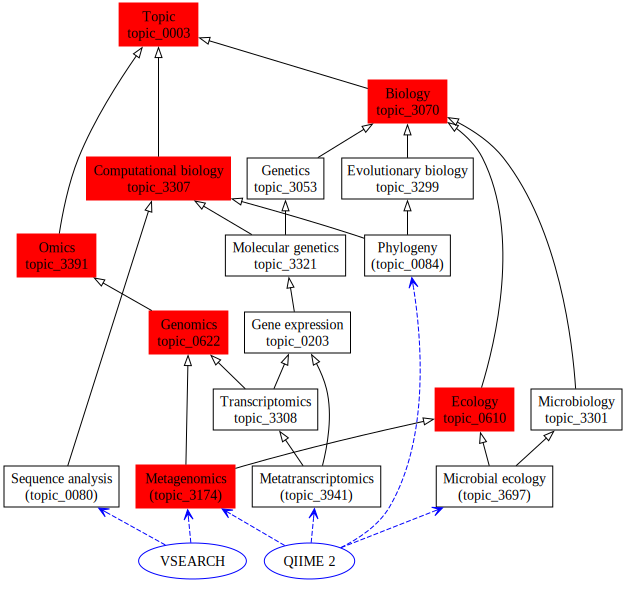

In [20]:
tools = ["qiime2","vsearch"]
nbTools = len(dfTool)

fileFormat = "png"

listToolURI = [biotoolsURI+x for x in tools]
commonGraph = addToolsAndAnnotationsToGraph(listToolURI, graph=None, showTopics=True, showOperations=False, highlightDirectAnnotations=False, highlightIntersection=True)
display(IPython.core.display.SVG(commonGraph.draw(prog='dot',format='svg')))

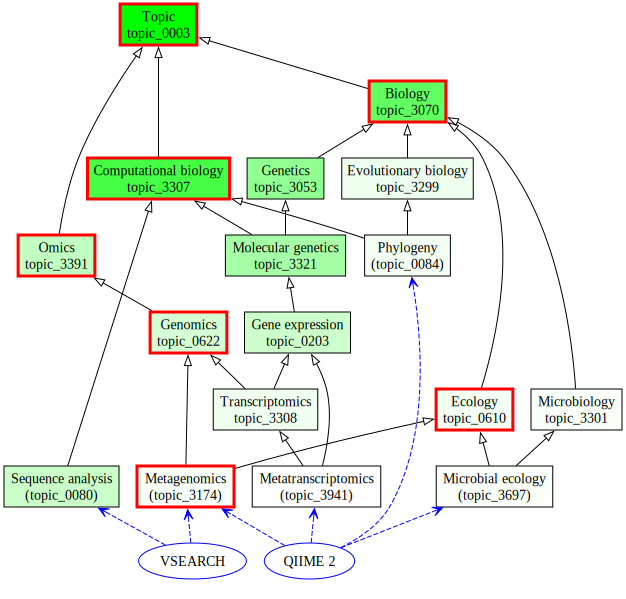

In [24]:
# color by the number of tools
dfTopicNbToolsTransitive = dfToolTopicTransitive[['tool', 'topic']].groupby(by=['topic'], as_index=False).size()
dictTopicNbToolsTransitive = {}
for (conceptURI, conceptNbTools) in dfTopicNbToolsTransitive[['topic', 'size']].set_index('topic').to_dict()['size'].items():
    dictTopicNbToolsTransitive[conceptURI.replace(edamURI, "")] = conceptNbTools

dfOperationNbToolsTransitive = dfToolOperationTransitive[['tool', 'operation']].groupby(by=['operation'], as_index=False).size()
dictOperationNbToolsTransitive = {}
for (conceptURI, conceptNbTools) in dfOperationNbToolsTransitive[['operation', 'size']].set_index('operation').to_dict()['size'].items():
    dictOperationNbToolsTransitive[conceptURI.replace(edamURI, "")] = conceptNbTools
    
dictTopicNbOccurrences = collections.defaultdict(lambda: 0)
dictOperationsNbOccurrences = collections.defaultdict(lambda: 0)

for currentTool in tools:
    for currentTopic in [x.replace(edamURI, "") for x in dfToolTopicTransitive[dfToolTopicTransitive['tool'] == biotoolsURI+currentTool]['topic'].to_list()]:
        dictTopicNbOccurrences[currentTopic] += 1
    for currentOperation in [x.replace(edamURI, "") for x in dfToolOperationTransitive[dfToolOperationTransitive['tool'] == biotoolsURI+currentTool]['operation'].to_list()]:
        dictOperationsNbOccurrences[currentOperation] += 1

# color by the number of tools
colorGraphNodesAccordingToScore(commonGraph, dictTopicNbToolsTransitive, dictOperationNbToolsTransitive, color="green")
display(IPython.core.display.SVG(commonGraph.draw(prog='dot',format='svg')))